<a href="https://colab.research.google.com/github/hardiksraja/Alphonso-Mango-Classification/blob/master/AlphansoMangoClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alphonso Mango classification

This notebook is used to classify whether a given input image is an alphonso mango. 

It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data. The Tensorflow and the Keras classes are needed to construct our model.

In [0]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

## Load data

Lets us the mount the google drive, where we have images for model training and validation

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Assign variables with the proper file path for the training and validation set.

In [0]:
root_dir = '/content/drive/My Drive/'
mangoFolder = 'mangoes/'
mango_dir = 'Colab Notebooks/data/' + mangoFolder
base_dir = root_dir + mango_dir
PATH = Path(base_dir)

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_alphonso_dir = os.path.join(train_dir, 'alphonso')  # directory with our training pictures of alphonso mango
train_othermangoes_dir = os.path.join(train_dir, 'othermangoes')  # directory with our training pictures of other mangoes
validation_mangoes_dir = os.path.join(validation_dir, 'alphonso')  # directory with our validation pictures of alphonso mango
validation_othermangoes_dir = os.path.join(validation_dir, 'othermangoes')  # directory with our validation pictures of other mangoes

print('Train Directory : ',train_dir)
print('Validation Directory : ',validation_dir)

Train Directory :  /content/drive/My Drive/Colab Notebooks/data/mangoes/train
Validation Directory :  /content/drive/My Drive/Colab Notebooks/data/mangoes/validation


The dataset has the following directory structure:

<pre>
<b>mangoes</b>
|__ <b>train</b>
    |______ <b>alphonso</b>: [00000000.jpg, 00000001.jpg, 00000003.jpg ....]
    |______ <b>othermangoes</b>: [00000000.jpg, 00000001.jpg, 00000003.jpg ...]
|__ <b>validation</b>
    |______ <b>alphonso</b>: [00000256.jpg, 00000257.jpg, 00000258.jpg ....]
    |______ <b>othermangoes</b>: [00000336.jpg, 00000336.jpg, 00000336.jpg ...]
</pre>

### Understand the data

Let's look at how many alphonso and othermangoes images are in the training and validation directory:

In [0]:
num_alphonso_tr = len(os.listdir(train_alphonso_dir))
num_othermangoes_tr = len(os.listdir(train_othermangoes_dir))

num_alphonso_val = len(os.listdir(validation_mangoes_dir))
num_othermangoes_val = len(os.listdir(validation_othermangoes_dir))

total_train = num_alphonso_tr + num_othermangoes_tr
total_val = num_alphonso_val + num_othermangoes_val

In [6]:
print('total training alphonso images:', num_alphonso_tr)
print('total training other mangoe images:', num_othermangoes_tr)

print('total validation mango images:', num_alphonso_val)
print('total validation other mangoe images:', num_othermangoes_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training alphonso images: 183
total training other mangoe images: 170
total validation mango images: 78
total validation other mangoe images: 102
--
Total training images: 353
Total validation images: 180


For our convenience, set up variables to use while pre-processing the dataset and training the network.

In [0]:
batch_size = 50
epochs = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Data preparation

Lets format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert them into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

All these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors which will be helpful when training the network.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator=ImageDataGenerator(rescale=1./255) # Generator for our validation data

Post defining the generators for training and validation images, the `flow_from_directory` method will load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 353 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 180 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 50 images in this notebook—then lets plot 20 of them with `matplotlib`.

In [0]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Here we discard the labels (i.e y_train) to only visualize the training images.

In [12]:
print('Shape of a batch : ', sample_training_images.shape)

Shape of a batch :  (50, 224, 224, 3)


**In above output (x1, x2, x3, x4)**

1. x1:No of Images in batch
2. x2:Height of Image (In Pixels)
3. x3:Width of Image (In Pixels)
4. x4:No of Channels in Image (3 channels i.e. Red, Green , Blue)

In [0]:
# This function will plot images in the form of a grid with 5 row and 4 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

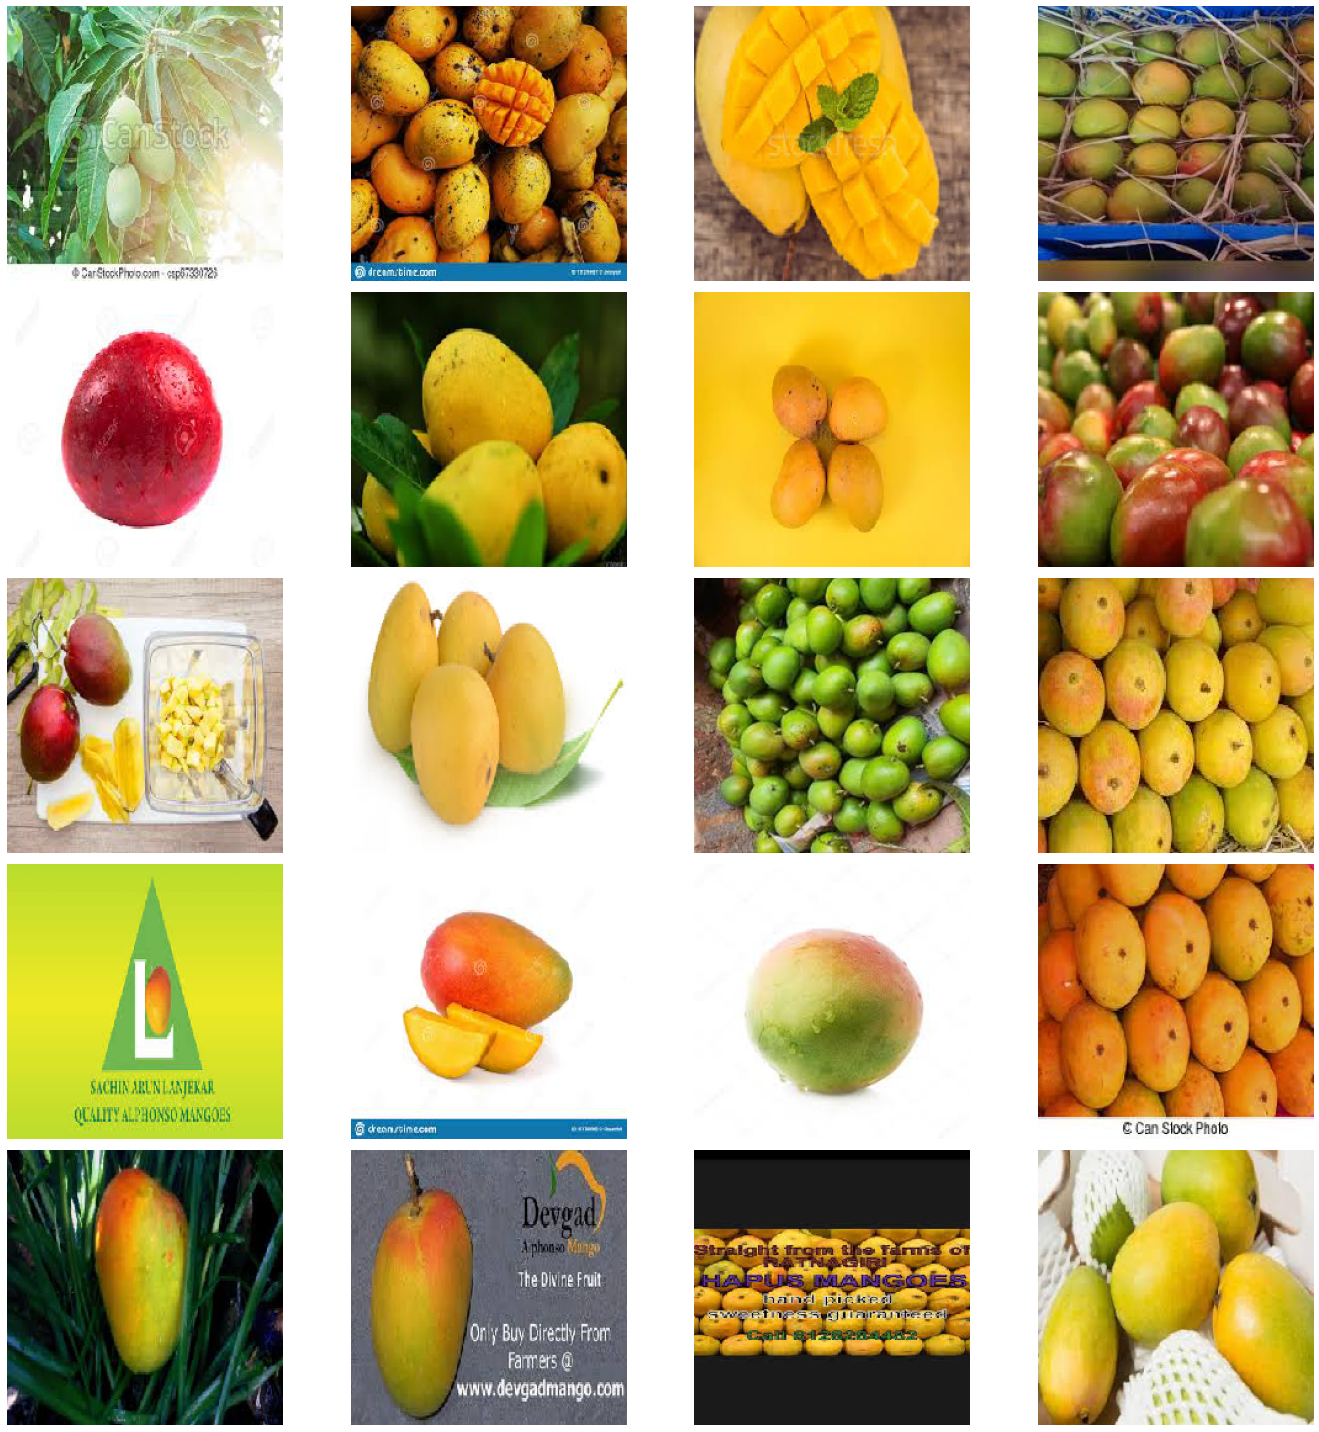

In [14]:
plotImages(sample_training_images[:20])

## Create a first simple model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

Lets choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

Lets view all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

### Train the model

Use the `fit` method to train the network.

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/20
7/7 [==============================] - 115s 16s/step - loss: 1.9722 - accuracy: 0.4785 - val_loss: 0.6824 - val_accuracy: 0.5667
Epoch 2/20
7/7 [==============================] - 2s 220ms/step - loss: 0.6916 - accuracy: 0.5380 - val_loss: 0.6854 - val_accuracy: 0.4467
Epoch 3/20
7/7 [==============================] - 2s 236ms/step - loss: 0.6654 - accuracy: 0.5149 - val_loss: 0.6668 - val_accuracy: 0.4067
Epoch 4/20
7/7 [==============================] - 2s 237ms/step - loss: 0.6333 - accuracy: 0.5347 - val_loss: 0.6062 - val_accuracy: 0.5467
Epoch 5/20
7/7 [==============================] - 2s 239ms/step - loss: 0.5138 - accuracy: 0.7228 - val_loss: 0.5483 - val_accuracy: 0.6800
Epoch 6/20
7/7 [==============================] - 2s 235ms/step - loss: 0.4673 - accuracy: 0.7756 - val_loss: 0.5995 - val_accuracy: 0.6800
Epoch 7/20
7/7 [==============================] - 2s 235ms/step - loss: 0.5449 - accuracy: 0.7459 - val_loss: 0.5644 - val_accuracy: 0.6733
Epoch 8/20
7/7 [====

### Visualize training results

Lets visualize the results after training the network.

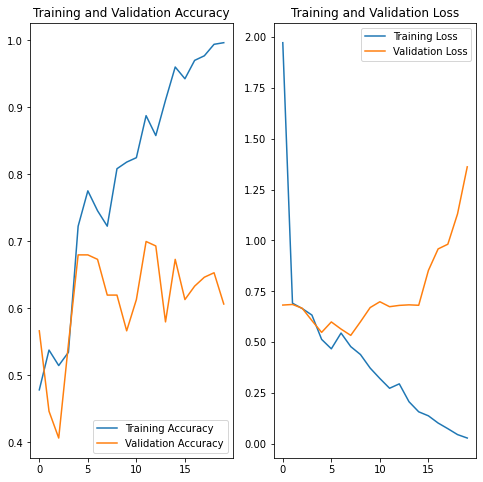

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **64%** accuracy on the validation set.

Let's analyze on what went wrong and try to increase overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 64% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable i.e a sign of *overfitting*.

When there are a small number of training images/examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. Below we will try to fight overfitting by using *data augmentation* and add *dropout* to our model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

This is implement in `tf.keras` using the `ImageDataGenerator` class. We need to Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Applying different augmentations all together and Create the training set

Here we Apply all the following augmentations; rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [21]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 353 images belonging to 2 classes.


Lets Visualize how a single mango image would look five different times when passing these augmentations randomly to the dataset.

In [0]:
def plotImagesH(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

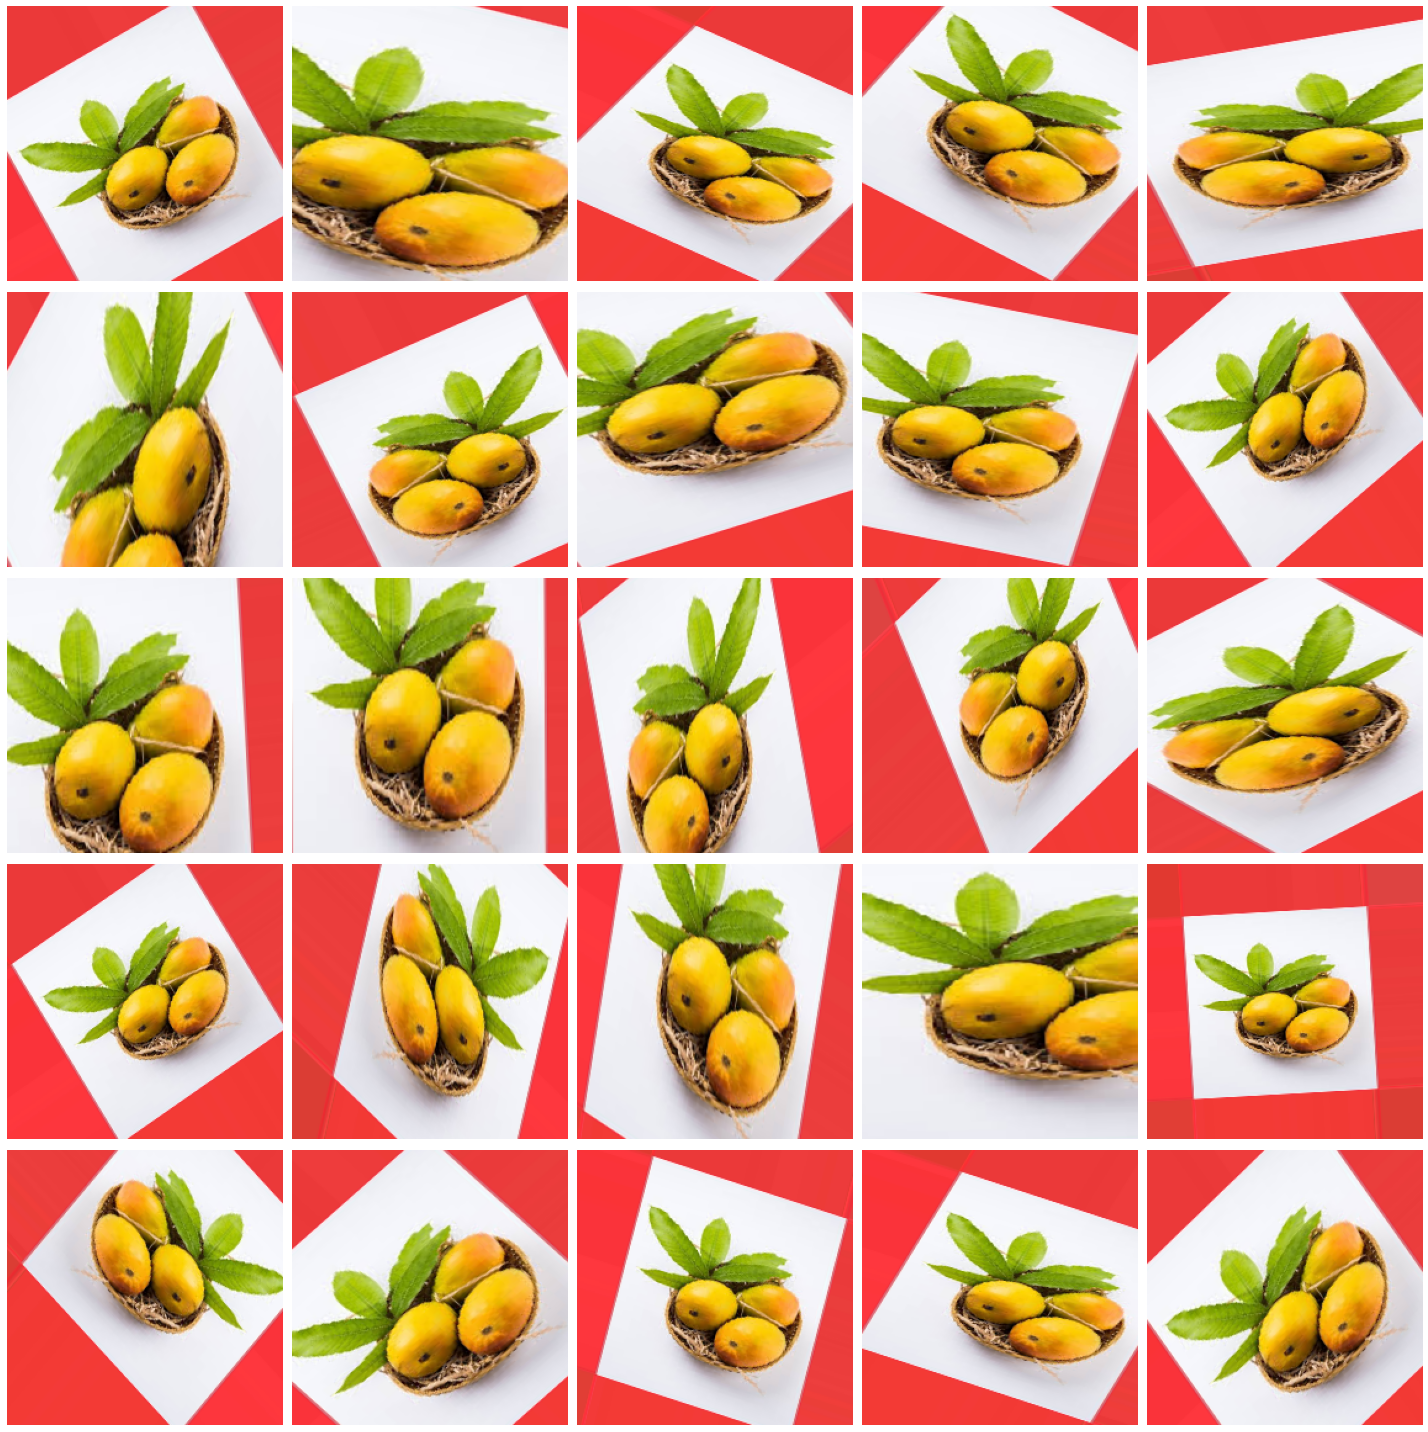

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(25)]
plotImagesH(augmented_images)

### Create validation data generator

We Generally, only apply data augmentation to the training examples. In this case, we  will only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [25]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 180 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this notebook

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Now lets create a new network architecture with this dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Here, we apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This will help to avoid overfitting on the training dataset.

In [0]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, lets compile the model and view the layers summary.

In [27]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, lets train this new network:

In [28]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/20
7/7 [==============================] - 4s 596ms/step - loss: 2.1419 - accuracy: 0.5083 - val_loss: 0.7092 - val_accuracy: 0.4400
Epoch 2/20
7/7 [==============================] - 4s 577ms/step - loss: 0.7241 - accuracy: 0.5149 - val_loss: 0.6916 - val_accuracy: 0.4267
Epoch 3/20
7/7 [==============================] - 5s 660ms/step - loss: 0.6897 - accuracy: 0.5116 - val_loss: 0.6911 - val_accuracy: 0.4200
Epoch 4/20
7/7 [==============================] - 4s 589ms/step - loss: 0.6854 - accuracy: 0.5314 - val_loss: 0.6820 - val_accuracy: 0.4133
Epoch 5/20
7/7 [==============================] - 4s 602ms/step - loss: 0.6559 - accuracy: 0.5941 - val_loss: 0.6560 - val_accuracy: 0.5000
Epoch 6/20
7/7 [==============================] - 4s 584ms/step - loss: 0.6619 - accuracy: 0.5941 - val_loss: 0.6842 - val_accuracy: 0.5333
Epoch 7/20
7/7 [==============================] - 4s 591ms/step - loss: 0.6585 - accuracy: 0.6271 - val_loss: 0.6658 - val_accuracy: 0.4600
Epoch 8/20
7/7 [====

### Visualize the model

Visualize the new model after training, we can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

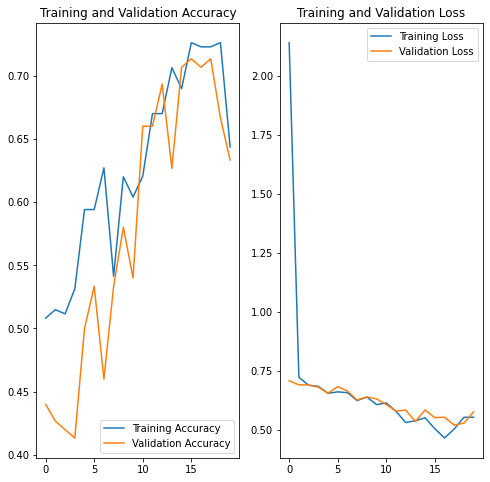

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is a way to use pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models. Here we will demonstrate the following:

1. Use TensorFlow Hub with `tf.keras`.
2. Perform image classification using TensorFlow Hub.
3. Perform simple transfer learning.

## Setup

In [0]:
# # For uninstalling current version: 
# !pip uninstall tensorflow

# # For installing the current version: 
# !pip install --upgrade tensorflow

# # View the installed version of tensorflow
# !pip show tensorflow

In [0]:
# !pip install tf-nightly
# !pip install -U tf-hub-nightly
# !pip install tfds-nightly

In [0]:
import tensorflow_hub as hub
from tensorflow.keras import layers

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classe i.e Alphonso Mango in our dataset.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
  hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))                                  
])

In [35]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


Now, we get the `image_batch, label_batch` pairs from the respective Image Iterators for the training and validation set of images 

In [36]:
for image_batch, label_batch in train_data_gen:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (50, 224, 224, 3)
Label batch shape:  (50,)


In [37]:
for image_val_batch, label_val_batch in val_data_gen:
  print("Image batch shape: ", image_val_batch.shape)
  print("Label batch shape: ", label_val_batch.shape)
  break

Image batch shape:  (50, 224, 224, 3)
Label batch shape:  (50,)


### Fetch the ImageNet labels

In [38]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


### Run the classifier on a batch of images

In [39]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(50, 1001)

In [40]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['croquet ball', 'lemon', 'spaghetti squash', 'cucumber',
       'spaghetti squash', 'spaghetti squash', 'ear', 'slug',
       'strawberry', 'corn', 'broom', 'corn', 'theater curtain',
       'spaghetti squash', 'lemon', 'French loaf', 'spaghetti squash',
       'custard apple', 'pomegranate', 'rubber eraser', 'corn',
       'tennis ball', 'corn', 'pill bottle', 'spaghetti squash',
       'Granny Smith', 'handkerchief', 'chime', 'lemon', 'jackfruit',
       'punching bag', 'spaghetti squash', 'lemon', 'spaghetti squash',
       'packet', 'tennis ball', 'lemon', 'cabbage butterfly',
       'pill bottle', 'lemon', 'Granny Smith', 'carton', 'orange',
       'lemon', 'spaghetti squash', 'lemon', 'spaghetti squash',
       'Granny Smith', 'cucumber', 'banana'], dtype='<U30')

Now check how these predictions line up with the images:

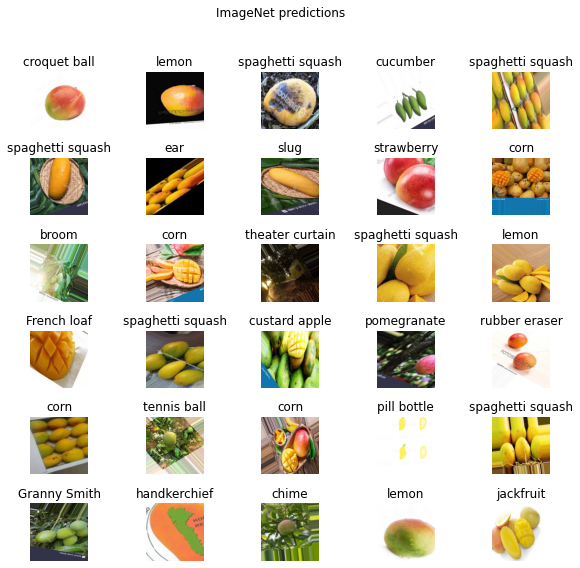

In [41]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning. Lets download that.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Lets create the feature extractor.

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [44]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(50, 1280)


Lets freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [0]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now here we wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer on top of it.

In [46]:
train_data_gen.num_classes #TODO

2

In [47]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  # layers.Dense(train_data_gen.num_classes)
  layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [49]:
predictions.shape

TensorShape([50, 1])

### Train the model

We use compile to configure the training process:

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

Now we use the `.fit` method to train the model.

To visualize the training progress, we use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [72]:
batch_stats_callback = CollectBatchStats()
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks = [batch_stats_callback]
)

Epoch 1/20
7/7 [==============================] - 5s 699ms/step - loss: 0.1649 - acc: 0.9200 - val_loss: 0.4457 - val_acc: 0.7600
Epoch 2/20
7/7 [==============================] - 5s 671ms/step - loss: 0.1503 - acc: 0.9600 - val_loss: 0.4392 - val_acc: 0.7933
Epoch 3/20
7/7 [==============================] - 4s 639ms/step - loss: 0.2230 - acc: 0.9000 - val_loss: 0.4254 - val_acc: 0.7800
Epoch 4/20
7/7 [==============================] - 4s 641ms/step - loss: 0.2284 - acc: 0.8800 - val_loss: 0.4567 - val_acc: 0.7733
Epoch 5/20
7/7 [==============================] - 4s 638ms/step - loss: 0.2627 - acc: 0.8800 - val_loss: 0.4436 - val_acc: 0.7600
Epoch 6/20
7/7 [==============================] - 5s 659ms/step - loss: 0.1898 - acc: 0.9400 - val_loss: 0.4658 - val_acc: 0.7333
Epoch 7/20
7/7 [==============================] - 5s 730ms/step - loss: 0.2037 - acc: 0.9000 - val_loss: 0.3709 - val_acc: 0.8000
Epoch 8/20
7/7 [==============================] - 4s 638ms/step - loss: 0.2419 - acc: 0.94

### Visualize the model

Now we will Visualize the new model after training.

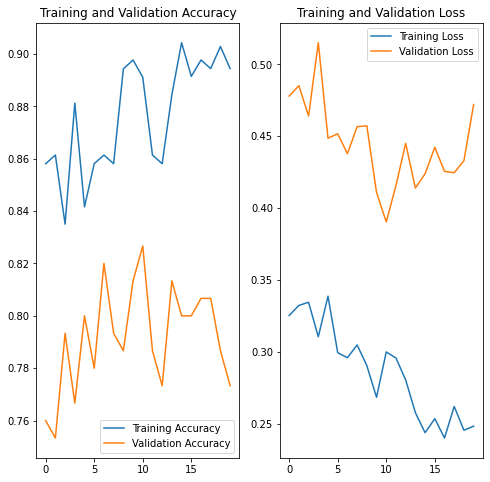

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

we can see that there is significantly less overfitting than before.

Now post a few training iterations, we can see that the model is making progress on the task.

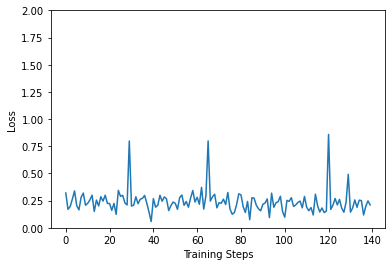

In [73]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

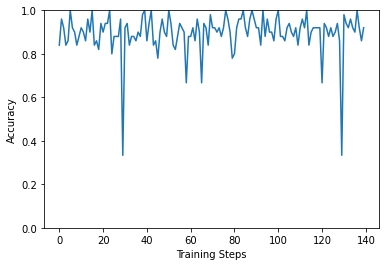

In [74]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

First lets get the ordered list of class names:

In [75]:
class_names = sorted(val_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Alphonso', 'Othermangoes'], dtype='<U12')

Lets run the image batch in the validation set through the model and convert the indices to class names.

In [0]:
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Lets Plot the result for the 1st Batch of Validation Set

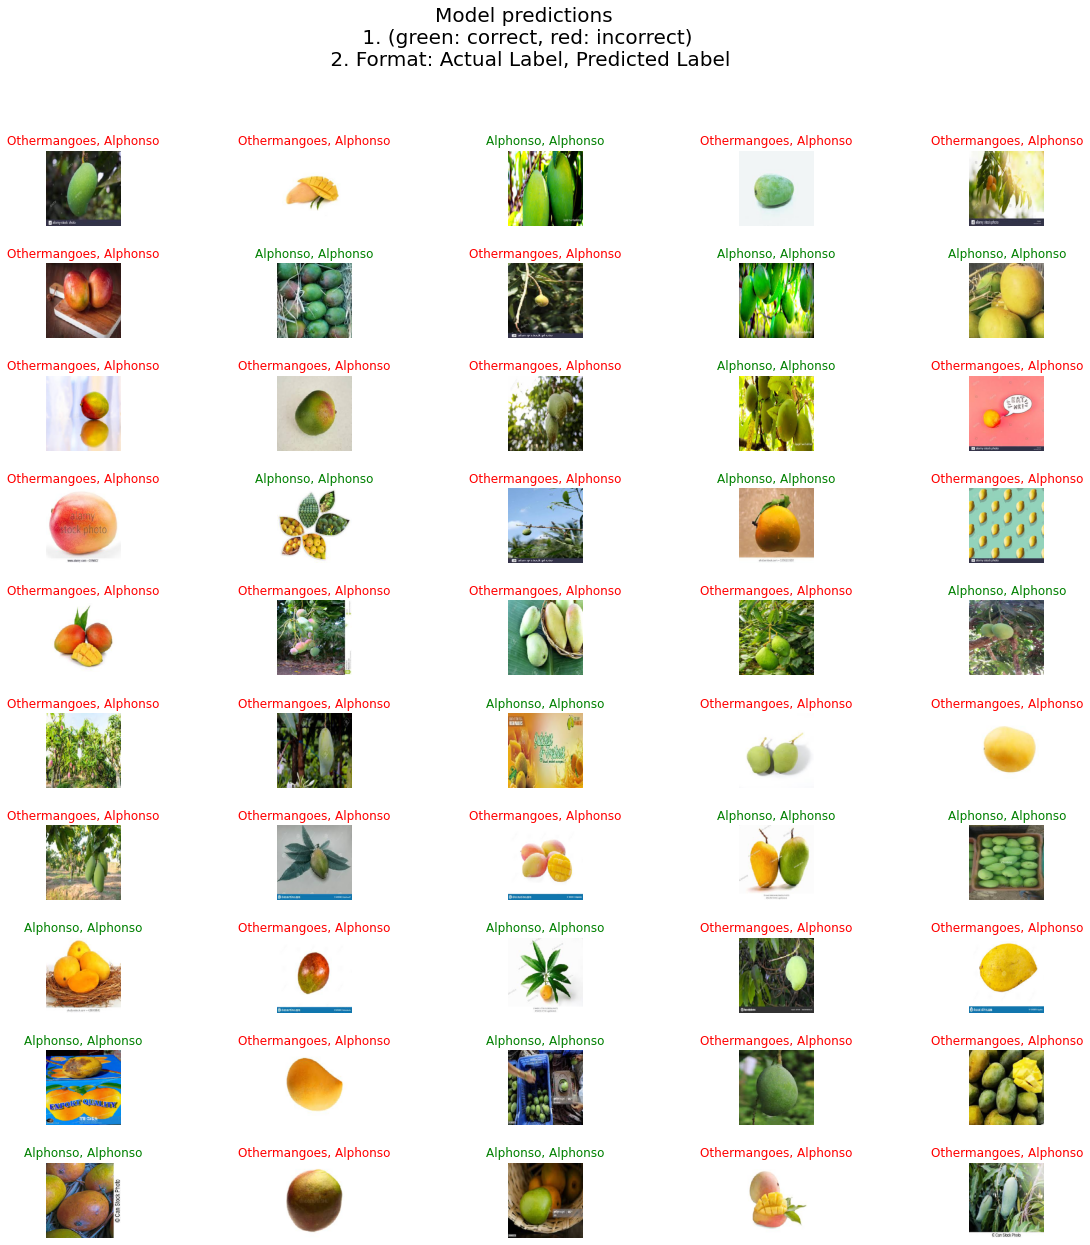

In [99]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(50):
  plt.subplot(10,5,n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_val_batch[n] else "red"
  plt.title(class_names[(label_val_batch[n]).astype(int)]  +", "  +predicted_label_batch[n].title() , color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions \n 1. (green: correct, red: incorrect) \n 2. Format: Actual Label, Predicted Label", fontsize=20)

For checking predictions of other batches in the validation set, Kindly uncomment and execute the below code snippets repeateadly

In [0]:
# image_val_batch, label_val_batch = next(val_data_gen)

In [0]:
# predicted_batch = model.predict(image_val_batch)
# predicted_id = np.argmax(predicted_batch, axis=-1)
# predicted_label_batch = class_names[predicted_id]

In [0]:
# plt.figure(figsize=(20,20))
# plt.subplots_adjust(hspace=0.5)
# for n in range(50):
#   plt.subplot(10,5,n+1)
#   plt.imshow(image_val_batch[n])
#   color = "green" if predicted_id[n] == label_val_batch[n] else "red"
#   plt.title(class_names[(label_val_batch[n]).astype(int)]  +", "  +predicted_label_batch[n].title() , color=color)
#   plt.axis('off')
# _ = plt.suptitle("Model predictions \n 1. (green: correct, red: incorrect) \n 2. Format: Actual Label, Predicted Label", fontsize=20)

## Export your model

Now that you've trained the model, export it as a saved model:

In [117]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1590773759/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1590773759/assets


'/tmp/saved_models/1590773759'

Now lets confirm that we can reload it, and it still gives the same results:

In [0]:
reloaded = tf.keras.models.load_model(export_path)

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [121]:
abs(reloaded_result_batch - result_batch).max()

0.0